In [128]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.gridspec as gridspec

start = time.time()

root = './MNIST_data/'
if not os.path.exists(root):
    os.mkdir(root)
trans = transforms.Compose([transforms.ToTensor()])
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
print( "torch.device is", device)

train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)
batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print("==>>> total trainning batch number: {}".format(len(train_loader)))
print("==>>> total testing batch number: {}".format(len(test_loader)))
print("==>>> total number of batches are: {}".format(batch_size))

for index, batch in enumerate(train_loader):
    inputs = batch[0]
    labels = batch[1]
    if(index == 0):
        print("==>>> input shape of a batch is: {}".format(inputs.shape))
        print("==>>> labels shape of a batch is: {}".format(labels.shape))
        print(inputs[0].shape, labels[0].shape)
        


torch.device is cpu
==>>> total trainning batch number: 600
==>>> total testing batch number: 100
==>>> total number of batches are: 100
==>>> input shape of a batch is: torch.Size([100, 1, 28, 28])
==>>> labels shape of a batch is: torch.Size([100])
torch.Size([1, 28, 28]) torch.Size([])


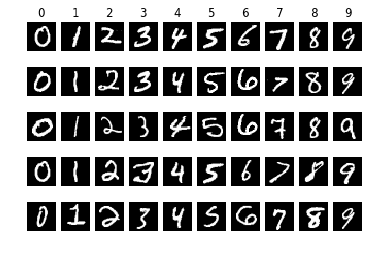

In [129]:
plt.gray()
inputs = inputs.numpy()
labels = labels.numpy()
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=True)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        im = inputs[idx].reshape(28,28)
        plt.imshow((im*255).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()
    

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Iter-0; D_loss: 1.3526004552841187; G_loss: 1.1853317022323608
Iter-1000; D_loss: 0.07810766994953156; G_loss: 6.965250015258789
Iter-2000; D_loss: 0.03199801221489906; G_loss: 5.019338607788086
Iter-3000; D_loss: 0.06235239654779434; G_loss: 6.165184497833252
Iter-4000; D_loss: 0.1160142570734024; G_loss: 3.5538101196289062
Iter-5000; D_loss: 0.11404436826705933; G_loss: 3.4413559436798096
Iter-6000; D_loss: 0.1784381866455078; G_loss: 3.5619308948516846
Iter-7000; D_loss: 0.32336175441741943; G_loss: 3.043837785720825
Iter-8000; D_loss: 0.39731329679489136; G_loss: 2.701132297515869
Iter-9000; D_loss: 0.5403169393539429; G_loss: 2.769855260848999
Iter-10000; D_loss: 0.500150740146637; G_loss: 2.7523529529571533
Iter-11000; D_loss: 0.46595627069473267; G_loss: 2.498493194580078
Iter-120

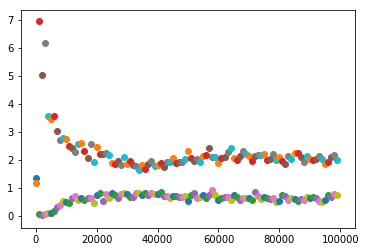

NameError: name 'model' is not defined

In [139]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

# Hyperparams
minibatch_size = 100;
z_dim = 100
X_dim = 784
h_dim = 128
y_dim = 1
lr = 1e-3
num_epochs = 100000
k = 1 
c = 0

########## DISCRIMINATOR ##############
D = nn.Sequential(
    nn.Linear(X_dim, h_dim),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(h_dim, y_dim),
    nn.Sigmoid()
    
).to(device)

########### GENERATOR #############
G = nn.Sequential(
    nn.Linear(z_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, X_dim),
    nn.Sigmoid()
).to(device)

def xavier_init(size):
    inp_dim = size[0]
    xavier_stddev = 1. / np.sqrt(inp_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

def reset_grad():
    G.zero_grad()
    D.zero_grad()

G_lossfn = optim.Adam(G.parameters(), lr)
D_lossfn = optim.Adam(D.parameters(), lr)

ones_label = Variable(torch.ones(minibatch_size, 1)).to(device)
zeros_label = Variable(torch.zeros(minibatch_size, 1)).to(device)

for epoch in range(num_epochs):
    z = Variable(xavier_init(size=[minibatch_size, z_dim]), requires_grad =True).to(device)
#     print("shape of z is: {}".format(z.shape))
    X, labels = mnist.train.next_batch(minibatch_size)
    X=X.reshape(100,784)
    X = Variable(torch.from_numpy(X), requires_grad=True).to(device)
#     print("shape of X is: {}".format(X.shape))
    labels = Variable(torch.from_numpy(labels)).to(device)
    G_sample = G(z).to(device)
#     print("shape of generated sample",G_sample.shape)
    D_real = D(X).to(device)   
#     print("shape of real sample",D_real.shape)
    D_fake = D(G_sample).to(device)
    loss = nn.BCELoss()
    D_loss_real = loss(D_real, ones_label)
    D_loss_fake = loss(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    D_lossfn.step()
    reset_grad()

    z = Variable(xavier_init(size= [minibatch_size, z_dim]), requires_grad = True).to(device)
    G_sample = G(z).to(device)
    D_fake = D(G_sample).to(device)
    G_loss = loss(D_fake, ones_label)
    G_loss.backward()
    G_lossfn.step()
    reset_grad()
        
#     print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.cpu().data.numpy(), G_loss.cpu().data.numpy()))
    if epoch % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.cpu().data.numpy(), G_loss.cpu().data.numpy()))
        plt.scatter(epoch, D_loss.cpu().data.numpy())
        plt.scatter(epoch, G_loss.cpu().data.numpy())
        samples = G(z).cpu().data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('GAN_output/'):
            os.makedirs('GAN_output/')

        plt.savefig('GAN_output/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        plt.close(fig)
end = time.time()
print("total time taken for training: {}".format(end - start))
plt.show()



In [146]:
state = {
    'epoch': epoch,
    'state_dict1': D.state_dict(),
    'state_dict2': G.state_dict(),
    'optimizer1': G_lossfn.state_dict(),
    'optimizer2': D_lossfn.state_dict(),
}
file_name = "checkpoint.pth"
torch.save(state, file_name)

In [152]:
state_dict = torch.load('checkpoint.pth')
print(state_dict['state_dict1'])

OrderedDict([('0.weight', tensor([[ 0.0373,  0.0614,  0.0367,  ...,  0.0568,  0.0324,  0.0446],
        [ 0.0272, -0.0081,  0.0140,  ...,  0.0071,  0.0093, -0.0002],
        [-0.0137,  0.0007,  0.0357,  ..., -0.0073, -0.0335,  0.0045],
        ...,
        [-0.0093,  0.0138,  0.0211,  ...,  0.0030,  0.0294, -0.0078],
        [-0.0919, -0.1110, -0.0811,  ..., -0.1163, -0.0672, -0.0941],
        [ 0.0461,  0.0637,  0.0117,  ...,  0.0615,  0.0303,  0.0233]])), ('0.bias', tensor([-2.5769e-01,  9.7521e-03, -1.8105e-02, -1.4862e+00, -1.1696e+00,
        -9.2679e-01,  2.3013e+00,  4.3936e-01, -7.6173e-01, -5.3791e-01,
        -2.9469e-01,  2.7739e-02, -9.6286e-01, -1.3218e+00, -3.1965e-01,
        -2.0883e+00, -2.6818e-01,  1.8400e+00, -2.6953e-01, -4.1122e-01,
        -3.5254e-02, -2.8023e-01, -2.9765e-01,  1.0221e+00, -1.3682e+00,
         1.5586e+00,  5.5396e-02,  1.8698e-02,  1.7213e+00, -4.7606e-01,
        -1.5504e+00, -9.7994e-03, -2.8473e+00,  1.5235e+00, -3.9384e+00,
        -1.2136e